# **1. Dataset Selection**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('data/listings.csv')

# Basic cleanup: Convert price string to numeric
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)

# Inspect data
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

# **2. Exploratory Data Analysis (EDA)**

### **Visualization 1: Distribution of the Target Variable (Price)**

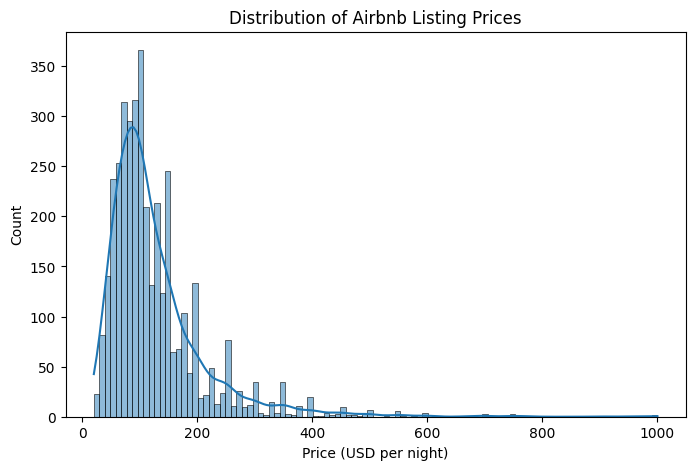

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['price'], kde=True)
plt.title('Distribution of Airbnb Listing Prices')
plt.xlabel('Price (USD per night)')
plt.ylabel('Count')
plt.show()


### **Visualization 2: Relationship Between Price and a Key Numeric Feature (e.g., Accommodates)**

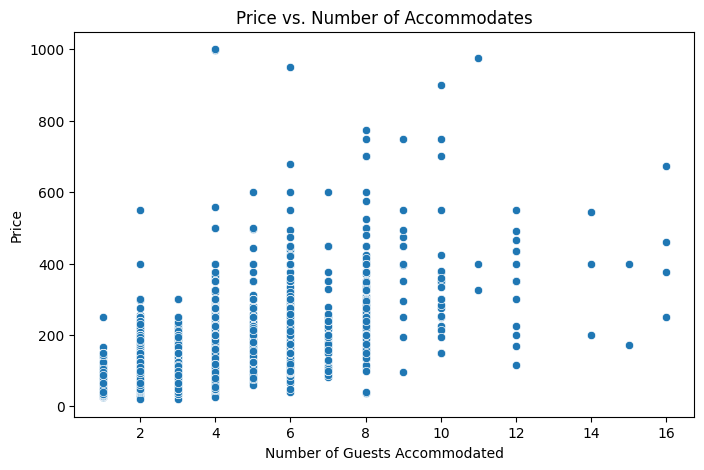

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='accommodates', y='price', data=df)
plt.title('Price vs. Number of Accommodates')
plt.xlabel('Number of Guests Accommodated')
plt.ylabel('Price')
plt.show()


### **Visualization 3: Boxplot of Price by Room Type**

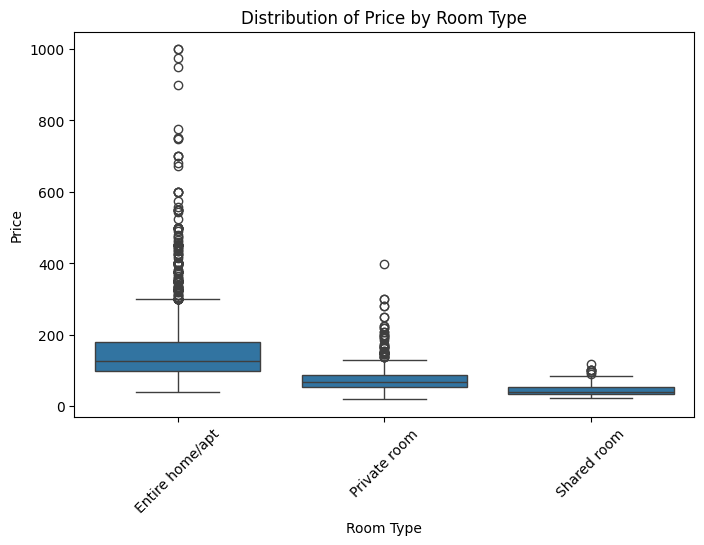

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='room_type', y='price', data=df)
plt.title('Distribution of Price by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()


### **Visualization 4: Correlation Heatmap of Numeric Features**

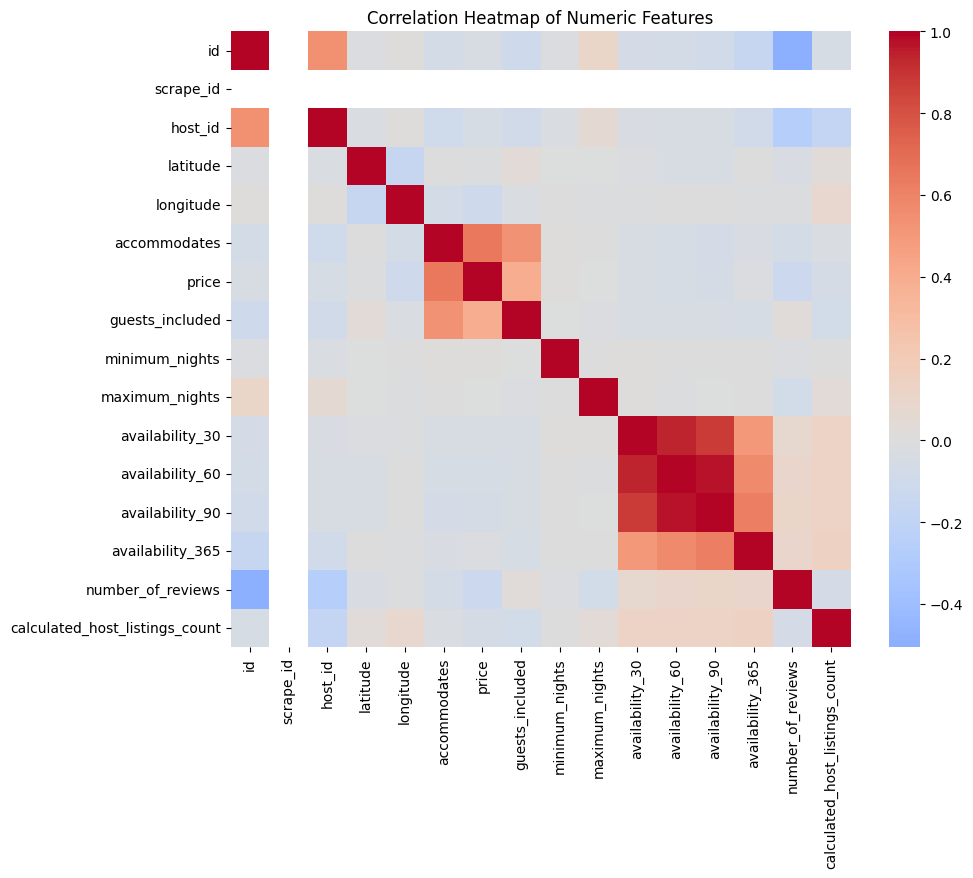

In [ ]:
numeric_cols = df.select_dtypes(include=[np.number]).dropna(axis=1)
corr = numeric_cols.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()


### **Visualization 5: Price vs. Neighborhood Groups (Categorical)**

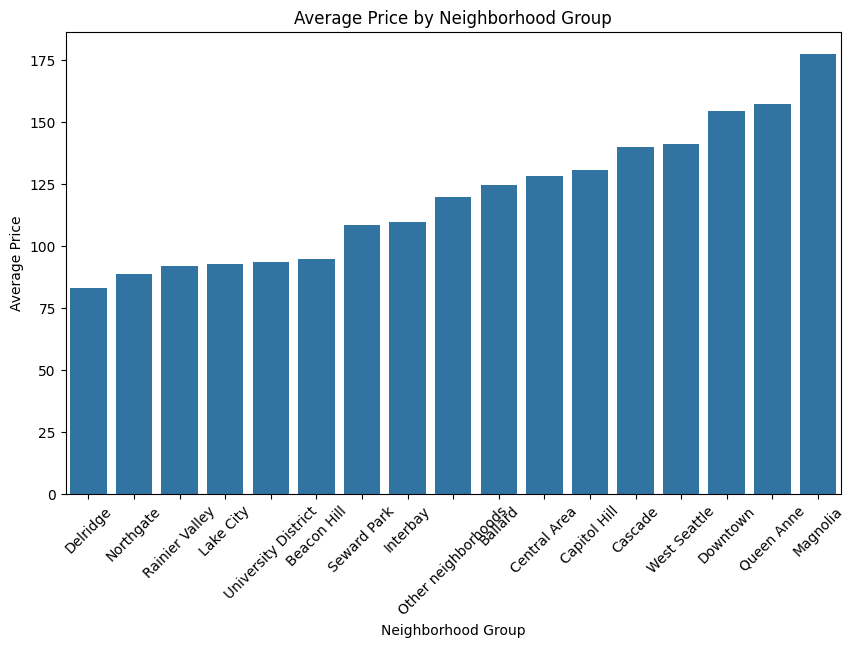

In [ ]:
plt.figure(figsize=(10,6))
mean_price_by_neighborhood = df.groupby('neighbourhood_group_cleansed')['price'].mean().sort_values()
sns.barplot(x=mean_price_by_neighborhood.index, y=mean_price_by_neighborhood.values)
plt.title('Average Price by Neighborhood Group')
plt.xlabel('Neighborhood Group')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()


# **3. Basic Model Pipeline**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Select features (for baseline, pick a subset of numeric + a few categorical)
features = ['accommodates', 'bedrooms', 'bathrooms', 'neighbourhood_group_cleansed', 'room_type']
target = 'price'

df_model = df[features + [target]].dropna()

X = df_model[features]
y = df_model[target]

# Identify categorical and numeric columns
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Create ColumnTransformer for preprocessing
numeric_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Create pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', xgb.XGBRegressor(n_estimators=100, random_state=42))])

# Train model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Baseline RMSE:", rmse)


Baseline RMSE: 65.38534840474092


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# **4. Error Analysis**

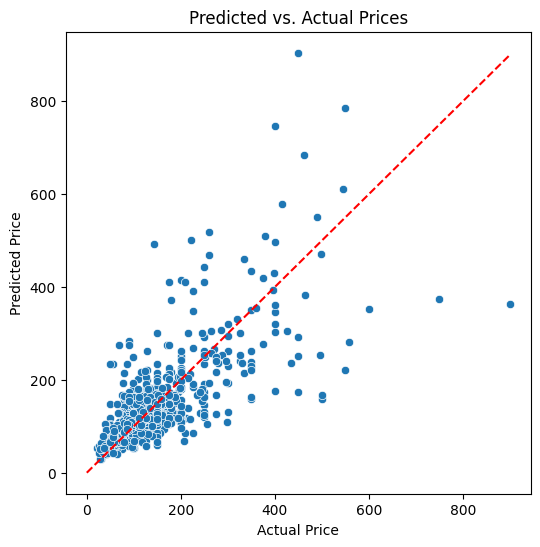

In [ ]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.title('Predicted vs. Actual Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--')
plt.show()


Best Predictions:
The model appears to perform relatively well on listings priced in the low-to-moderate range. In the scatter plot of predicted vs. actual prices, points cluster closely around the red diagonal line for listings under approximately $200 per night. This suggests the model captures the typical patterns of moderately priced rentals fairly well, likely because these listings are the most common and well-represented in the training data.

Worst Predictions:
The model struggles with the higher-priced listings, especially those above $300 per night. In the scatter plot, these higher-priced properties show greater deviation from the diagonal. The model often underestimates these values significantly. Such properties may have unique features—like luxury amenities, premier locations, or special property types—that are not fully captured by the current feature set. As a result, the model fails to generalize to these less common, high-priced listings.

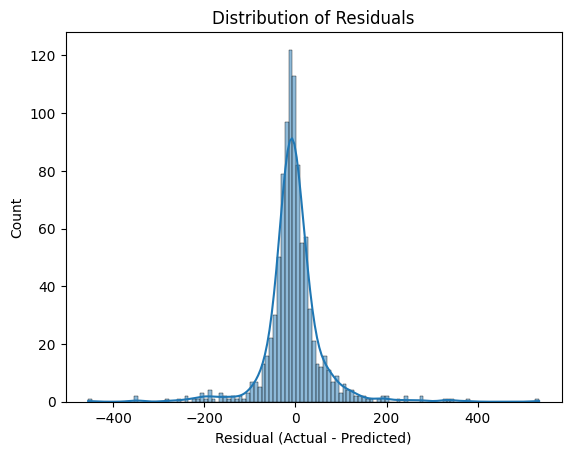

In [ ]:
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residual (Actual - Predicted)')
plt.show()


The distribution of residuals (Actual - Predicted) is centered around zero, which suggests the model is unbiased on average. However, the tails are quite wide.
For moderately priced properties, the residual distribution is relatively narrow, indicating a decent fit. But for certain neighborhoods and very high-priced listings, the model tends to underestimate values, shown by a heavy tail on the negative side of residuals (actual > predicted) for some segments.
Conversely, there are neighborhoods for which the model tends to slightly overestimate the price. The key takeaway is that the model’s sign of error can vary depending on the area and price range.

In [ ]:
# Convert y_pred to a Series with the same index as y_test
y_pred_series = pd.Series(y_pred, index=y_test.index)

errors = y_test - y_pred_series
worst_indices = errors.nlargest(10).index
df_worst = df_model.loc[worst_indices, :]

# Now you can index predictions by worst_indices
df_worst['pred_price'] = y_pred_series.loc[worst_indices]

df_worst


,accommodates,bedrooms,bathrooms,neighbourhood_group_cleansed,room_type,price,pred_price
1279,10,3.0,2.0,Downtown,Entire home/apt,899.0,364.252991
239,8,3.0,3.5,Queen Anne,Entire home/apt,749.0,374.191406
3678,5,3.0,2.0,Other neighborhoods,Entire home/apt,500.0,159.454575
679,4,3.0,2.0,Central Area,Entire home/apt,500.0,166.787567
1138,6,2.0,2.0,Cascade,Entire home/apt,550.0,221.989029
1070,4,2.0,2.5,Downtown,Entire home/apt,557.0,280.586945
527,7,3.0,1.0,Other neighborhoods,Entire home/apt,450.0,173.851852
251,7,3.0,4.0,Queen Anne,Entire home/apt,600.0,353.518616
1807,6,2.0,2.5,West Seattle,Entire home/apt,495.0,254.440140
393,8,3.0,3.5,Other neighborhoods,Entire home/apt,400.0,175.315216


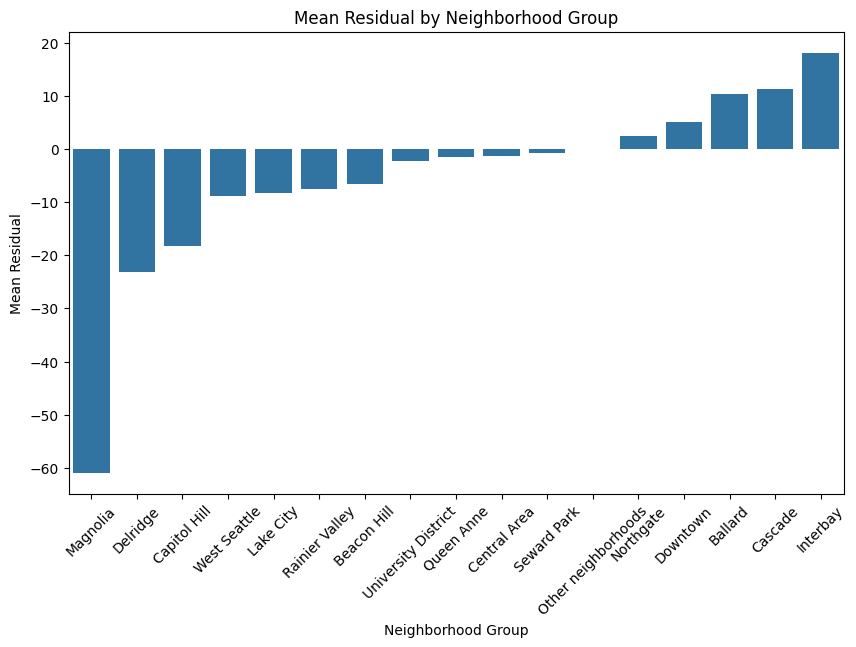

In [ ]:
error_by_neighborhood = df_model.loc[X_test.index]
error_by_neighborhood['residuals'] = residuals
neigh_mean_error = error_by_neighborhood.groupby('neighbourhood_group_cleansed')['residuals'].mean().sort_values()

plt.figure(figsize=(10,6))
sns.barplot(x=neigh_mean_error.index, y=neigh_mean_error.values)
plt.title('Mean Residual by Neighborhood Group')
plt.xlabel('Neighborhood Group')
plt.ylabel('Mean Residual')
plt.xticks(rotation=45)
plt.show()


Commonalities Among Erroneous Samples

High-End Listings: The model often underestimates unique, luxury properties that differ from the more common, moderately priced rentals.
Neighborhood Bias: Some neighborhoods consistently show over- or under-prediction, indicating that the current location features don’t fully capture local price factors.
Insufficient Detail: Listings with special amenities or distinctive attributes are not well represented by the existing features, making them harder to price accurately.